In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from PIL import Image
import requests
from io import BytesIO
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Embedding
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.callbacks import LearningRateScheduler
import string
import gensim
from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras import regularizers
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sean\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Tidying up data
1) Removed features that are unrelated to the card prices, such as the number and id.
2) Removed features that are repeated (such as pend_desc and monster_desc, both of which are already included in desc, also type, which overlaps with frameType.
3) Dropped some rows with missing information, such as some rows from card_sets.
4) filled empty cells with 0, as all the values are intentionally missing due to the properties of the cards (e.g. Spell and Trap cards do not have Attack and Defence points).
5) split up nested cells into multiple columns, such as card_sets and card_prices, which contain multivariate features but are shown in only 1 single cell.

In [102]:
import ast
import os

import os
card_df=pd.read_csv('card_data.csv')

# filepath='./artwork/artwork'
# dirlist=os.listdir(filepath)
# for i in card_df['id']:
#     imgpath='{}.jpg'.format(i)
#     if imgpath in dirlist:       
#         card_df[card_df['id']==i]['card_image']=plt.imread(os.path.join(filepath,imgpath))
#     else:
#         card_df[card_df['id']==i]['card_image']=0




#drop all empty card sets
card_df=card_df.dropna(subset='card_sets')
# card_df = card_df.sample(n=2000), random_state=42)

# Remove descriptions for Normal monsters
card_df['desc']=[str(card_df['desc'].iloc[x]) if (card_df['type'].iloc[x]!='Normal Monster') else '' for x in range(len(card_df)) ]
card_df['cardlength']=[len(word_tokenize(x.translate(str.maketrans('', '', string.punctuation)))) for x in card_df['desc']]

#seperate card sets into individual columns
temp=[ast.literal_eval(x) for x in card_df['card_sets'].values]
card_df['reprints']=[len(temp[x]) for x in range(len(temp))]
card_df['set_name']=[temp[x][0]['set_name'] for x in range(len(temp))]
card_df['set_rarity']=[temp[x][0]['set_rarity'] for x in range(len(temp))]
card_df['set_rarity_code']=[temp[x][0]['set_rarity_code'] for x in range(len(temp))]
card_df['set_price']=[temp[x][0]['set_price'] for x in range(len(temp))]
card_df=card_df.drop(['card_sets'],axis=1)

#seperate card images into individual columns
card_images=[ast.literal_eval(x) for x in card_df['card_images'].values]
image_url=[card_images[x][0]['image_url'] for x in range(len(card_images))]
image_url_small=[card_images[x][0]['image_url_small'] for x in range(len(card_images))]
image_url_cropped=[card_images[x][0]['image_url_cropped'] for x in range(len(card_images))]

#obtain images through the urls obtained
# dispimages=[Image.open(BytesIO(requests.get(x).content)) for x in image_url]
# card_df['card_images']=dispimages

#seperate card prices into individual columns
temp=[ast.literal_eval(x) for x in card_df['card_prices'].values]
card_df['cardmarket_price']=[float(temp[x][0]['cardmarket_price']) for x in range(len(temp))]
card_df['tcgplayer_price']=[float(temp[x][0]['tcgplayer_price']) for x in range(len(temp))]
card_df['ebay_price']=[float(temp[x][0]['ebay_price']) for x in range(len(temp))]
card_df['amazon_price']=[float(temp[x][0]['amazon_price']) for x in range(len(temp))]
card_df['coolstuffinc_price']=[float(temp[x][0]['coolstuffinc_price']) for x in range(len(temp))]
card_df=card_df.drop(['card_prices'],axis=1)

#drop unwanted columns
carddesc=card_df['desc']
card_df=card_df.drop(['card_images'],axis=1)
card_df=card_df.drop(['Unnamed: 0','id','frameType','pend_desc','monster_desc','desc','set_rarity_code','linkmarkers'],axis=1)

card_df=card_df.fillna(0)

card_df.head(5)

,name,type,race,archetype,atk,def,level,attribute,scale,linkval,...,cardlength,reprints,set_name,set_rarity,set_price,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price
0,"""A"" Cell Breeding Device",Spell Card,Continuous,Alien,0.0,0.0,0.0,0,0.0,0.0,...,16,1,Force of the Breaker,Common,1.31,0.10,0.19,0.99,24.45,0.25
1,"""A"" Cell Incubator",Spell Card,Continuous,Alien,0.0,0.0,0.0,0,0.0,0.0,...,32,1,Gladiator's Assault,Common,2.1,0.07,0.24,1.25,0.50,0.25
2,"""A"" Cell Recombination Device",Spell Card,Quick-Play,Alien,0.0,0.0,0.0,0,0.0,0.0,...,66,1,Invasion: Vengeance,Common,1.12,0.10,0.20,0.99,0.50,0.49
3,"""A"" Cell Scatter Burst",Spell Card,Quick-Play,Alien,0.0,0.0,0.0,0,0.0,0.0,...,22,1,Strike of Neos,Common,1.13,0.12,0.10,2.00,9.76,0.25
4,"""Infernoble Arms - Almace""",Spell Card,Equip,Noble Knight,0.0,0.0,0.0,0,0.0,0.0,...,89,2,Duelist Nexus,Quarter Century Secret Rare,0,0.00,0.64,0.00,0.00,0.00


In [103]:
card_df_val=card_df
# card_df_val=card_df_val.drop(['linkval'],axis=1)
dict_type=dict(enumerate(card_df.type.astype('category').cat.categories))
card_df_val.type=card_df_val.type.astype('category').cat.codes

card_df_val.race=card_df_val.race.astype('category').cat.codes
dict_race=dict(enumerate(card_df.race.astype('category').cat.categories))
card_df_val.archetype=card_df_val.archetype.astype('category').cat.codes
dict_archetype=dict(enumerate(card_df.archetype.astype('category').cat.categories))
card_df_val.banlist_info=card_df_val.banlist_info.astype('category').cat.codes
dict_banlist_info=dict(enumerate(card_df.banlist_info.astype('category').cat.categories))
card_df_val.attribute=card_df_val.attribute.astype('category').cat.codes
dict_attribute=dict(enumerate(card_df.attribute.astype('category').cat.categories))
card_df_val.set_name=card_df_val.set_name.astype('category').cat.codes
dict_set_name=dict(enumerate(card_df.set_name.astype('category').cat.categories))
card_df_val.set_rarity=card_df_val.sort_values(by=['set_rarity']).set_rarity.astype('category').cat.codes

card_df.head(5)
# print(card_df_val.coef_)
# card_df_val['set_price']

,name,type,race,archetype,atk,def,level,attribute,scale,linkval,...,cardlength,reprints,set_name,set_rarity,set_price,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price
0,"""A"" Cell Breeding Device",16,18,14,0.0,0.0,0.0,0,0.0,0.0,...,16,1,195,2,1.31,0.10,0.19,0.99,24.45,0.25
1,"""A"" Cell Incubator",16,18,14,0.0,0.0,0.0,0,0.0,0.0,...,32,1,206,2,2.1,0.07,0.24,1.25,0.50,0.25
2,"""A"" Cell Recombination Device",16,59,14,0.0,0.0,0.0,0,0.0,0.0,...,66,1,217,2,1.12,0.10,0.20,0.99,0.50,0.49
3,"""A"" Cell Scatter Burst",16,59,14,0.0,0.0,0.0,0,0.0,0.0,...,22,1,403,2,1.13,0.12,0.10,2.00,9.76,0.25
4,"""Infernoble Arms - Almace""",16,28,318,0.0,0.0,0.0,0,0.0,0.0,...,89,2,160,19,0,0.00,0.64,0.00,0.00,0.00


In [104]:
card_df_val.describe()

,type,race,archetype,atk,def,level,attribute,scale,linkval,banlist_info,cardlength,reprints,set_name,set_rarity,cardmarket_price,tcgplayer_price,ebay_price,amazon_price,coolstuffinc_price
count,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000,12374.000000
mean,10.200016,44.891789,144.009940,964.521578,773.945369,2.832229,2.338209,0.117181,0.074269,0.276144,51.829804,2.877323,147.767739,13.642638,1.102520,1.206034,4.180996,4.004826,1.409521
std,9.778390,20.822593,162.484927,1043.609438,916.361246,2.923383,2.374662,0.859954,0.449929,2.103662,28.909722,2.926368,127.718991,11.739748,12.514694,18.758122,29.553742,22.138586,11.782775
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,1.000000,30.000000,2.000000,0.090000,0.130000,0.990000,0.250000,0.250000
50%,8.000000,52.000000,73.000000,700.000000,300.000000,3.000000,1.000000,0.000000,0.000000,0.000000,50.000000,2.000000,116.000000,16.000000,0.150000,0.200000,1.250000,0.970000,0.390000
75%,18.000000,59.000000,280.000000,1800.000000,1500.000000,4.000000,5.000000,0.000000,0.000000,0.000000,75.000000,3.000000,232.000000,27.000000,0.320000,0.400000,2.750000,1.990000,0.790000
max,27.000000,85.000000,494.000000,5000.000000,5000.000000,13.000000,7.000000,13.000000,6.000000,25.000000,237.000000,61.000000,484.000000,31.000000,985.440000,999.990000,999.990000,999.990000,999.990000


array([[<Axes: title={'center': 'type'}>,
        <Axes: title={'center': 'race'}>,
        <Axes: title={'center': 'archetype'}>,
        <Axes: title={'center': 'atk'}>],
       [<Axes: title={'center': 'def'}>,
        <Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'attribute'}>,
        <Axes: title={'center': 'scale'}>],
       [<Axes: title={'center': 'linkval'}>,
        <Axes: title={'center': 'banlist_info'}>,
        <Axes: title={'center': 'cardlength'}>,
        <Axes: title={'center': 'reprints'}>],
       [<Axes: title={'center': 'set_name'}>,
        <Axes: title={'center': 'set_rarity'}>, <Axes: >, <Axes: >]],
      dtype=object)

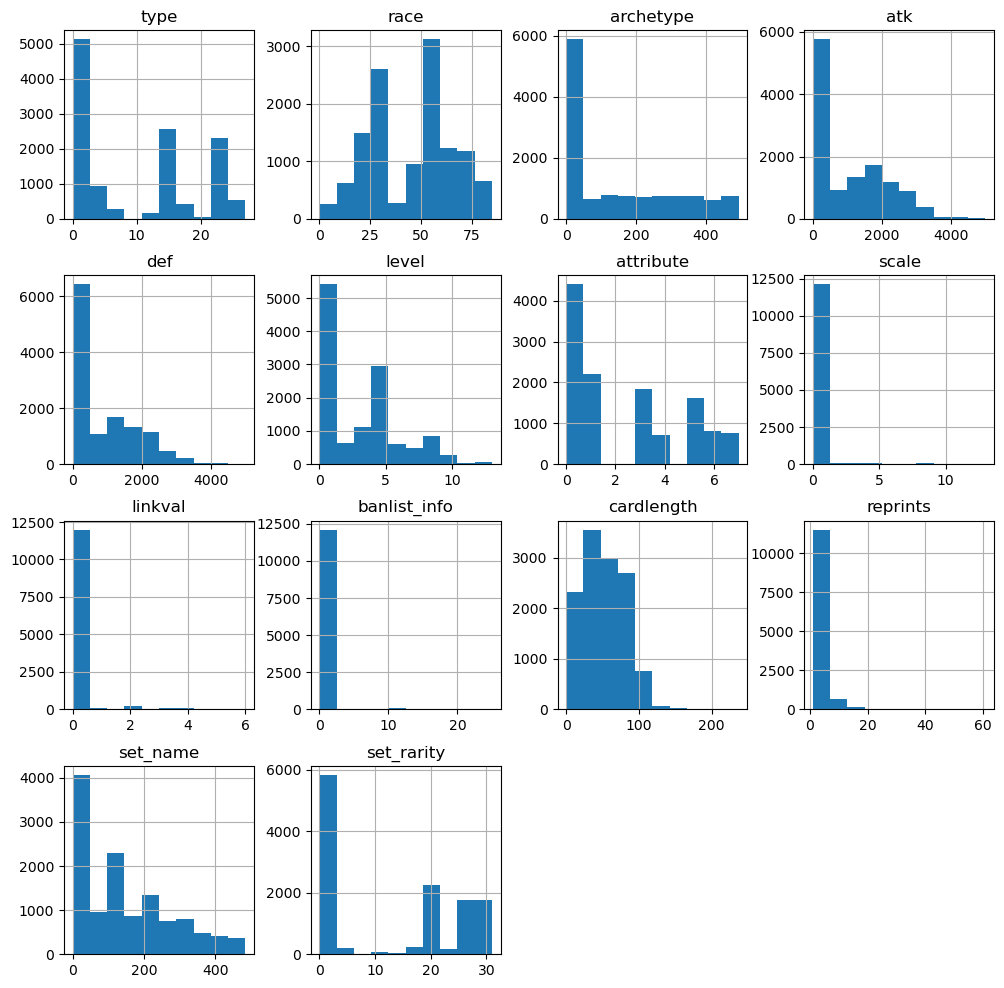

In [105]:
card_df_val.iloc[:,0:16].hist(figsize=(12,12),bins=10)

array([[<Axes: title={'center': 'cardmarket_price'}>,
        <Axes: title={'center': 'tcgplayer_price'}>],
       [<Axes: title={'center': 'ebay_price'}>,
        <Axes: title={'center': 'amazon_price'}>],
       [<Axes: title={'center': 'coolstuffinc_price'}>, <Axes: >]],
      dtype=object)

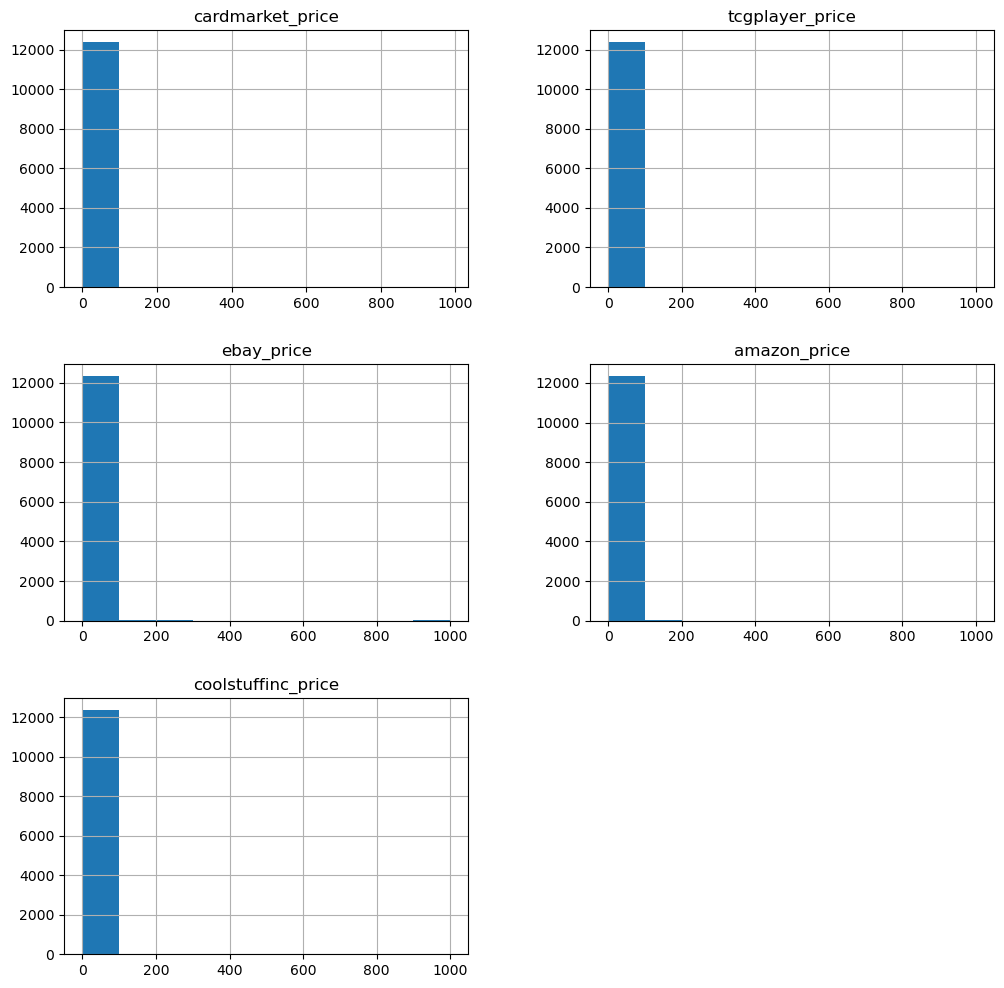

In [106]:
card_df_val.iloc[:,16:].hist(figsize=(12,12),bins=10)

In [107]:
card_df_val=card_df_val.drop(['cardmarket_price','ebay_price','amazon_price','coolstuffinc_price'],axis=1)

# Removing outliers

In [108]:
topquantile=card_df_val.tcgplayer_price.quantile(0.99)
print('Top Quantile is: {}'.format(topquantile))

card_df_val_final=card_df_val[card_df_val.tcgplayer_price>0]
card_df_val_final=card_df_val[card_df_val.tcgplayer_price<topquantile]
carddesc=carddesc[card_df_val.tcgplayer_price<topquantile]
card_df_val_final.describe()

Top Quantile is: 13.351600000000035


,type,race,archetype,atk,def,level,attribute,scale,linkval,banlist_info,cardlength,reprints,set_name,set_rarity,tcgplayer_price
count,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000,12250.000000
mean,10.203510,44.872245,144.190122,961.954286,771.489796,2.822612,2.336980,0.118286,0.073959,0.270612,51.803102,2.886857,146.970776,13.566776,0.536979
std,9.789188,20.822419,162.487810,1042.161894,914.516116,2.914706,2.375016,0.864178,0.448598,2.096962,28.814038,2.936690,126.917306,11.744219,1.225402
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,1.000000,30.000000,2.000000,0.120000
50%,8.000000,49.500000,74.000000,600.000000,300.000000,3.000000,1.000000,0.000000,0.000000,0.000000,50.000000,2.000000,116.000000,13.000000,0.200000
75%,18.000000,59.000000,280.000000,1800.000000,1500.000000,4.000000,5.000000,0.000000,0.000000,0.000000,75.000000,3.000000,230.000000,27.000000,0.390000
max,27.000000,85.000000,494.000000,5000.000000,5000.000000,13.000000,7.000000,13.000000,6.000000,25.000000,237.000000,61.000000,484.000000,31.000000,13.330000


# Standardization

array([[<Axes: title={'center': 'type'}>,
        <Axes: title={'center': 'race'}>,
        <Axes: title={'center': 'archetype'}>,
        <Axes: title={'center': 'atk'}>],
       [<Axes: title={'center': 'def'}>,
        <Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'attribute'}>,
        <Axes: title={'center': 'scale'}>],
       [<Axes: title={'center': 'linkval'}>,
        <Axes: title={'center': 'banlist_info'}>,
        <Axes: title={'center': 'cardlength'}>,
        <Axes: title={'center': 'reprints'}>],
       [<Axes: title={'center': 'set_name'}>,
        <Axes: title={'center': 'set_rarity'}>,
        <Axes: title={'center': 'set_price'}>, <Axes: >]], dtype=object)

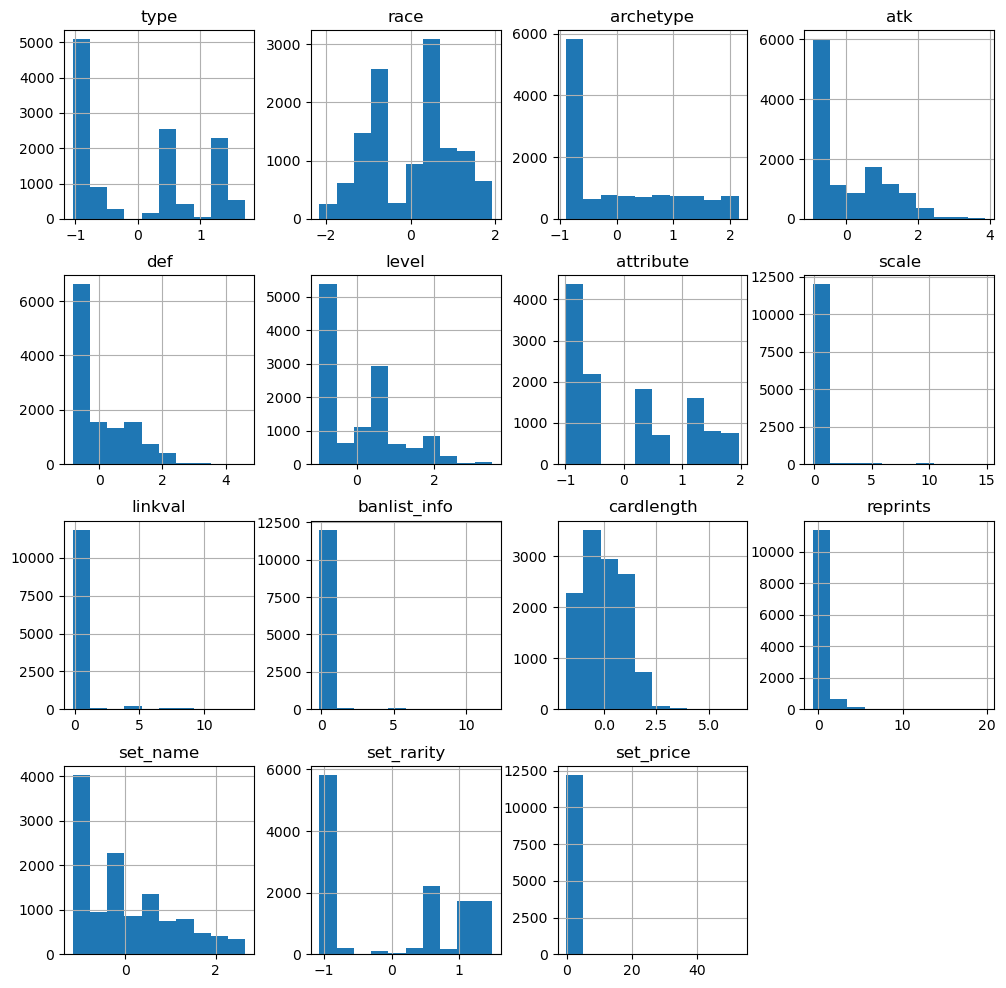

In [110]:
#Standardisation

scaler = StandardScaler()
columns=card_df.iloc[:,1:16].columns
X=card_df_val_final.iloc[:,1:16].to_numpy()
y=card_df_val_final.iloc[:,16].to_numpy()
X=np.double(X)
y=np.double(y)
# y=np.average(np.double(y),axis=1)
# print(y[0])

X_scaled=X

# X_scaled = scaler.fit_transform(X)
# # print(X.shape)
# X_df=pd.DataFrame(X_scaled,columns=columns)
# X_df.hist(figsize=(12,12))
# X_scaled[0]
# card_df_val.head

# Correlation Chart

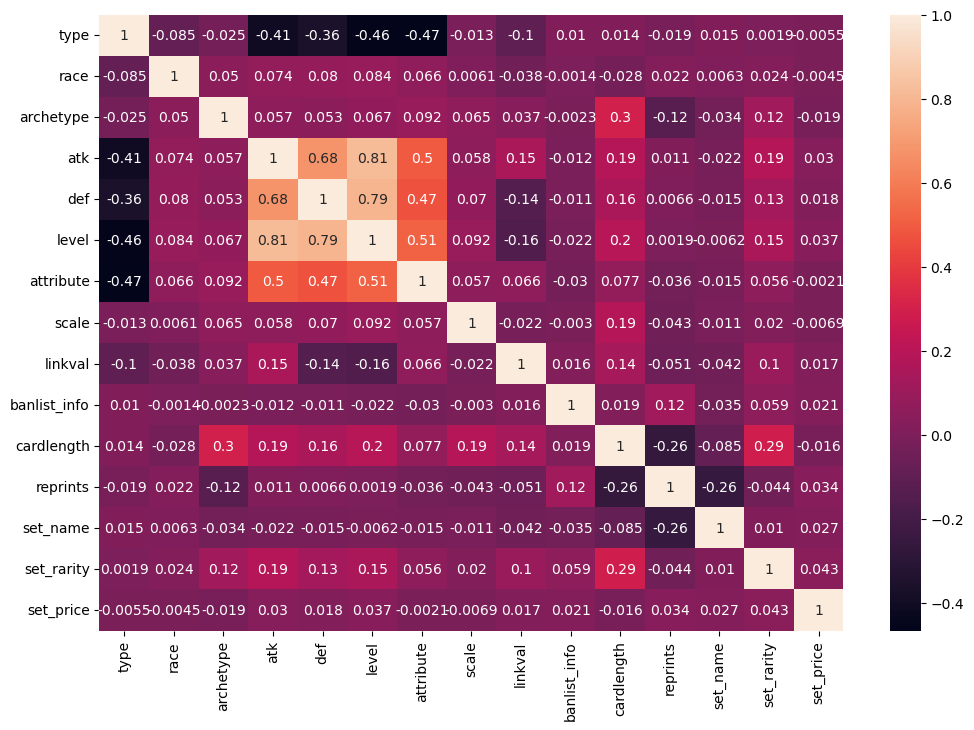

In [111]:
plt.figure(figsize=(12,8))
card_cor = card_df_val.iloc[:,1:16].corr()
sns.heatmap(card_cor, annot=True)
plt.show()

# NLP

In [260]:
max_length=0
min_length=20
for x in carddesc:
    tokens=word_tokenize(x.translate(str.maketrans('', '', string.punctuation)))
    if(max_length<len(tokens)):
        max_length=len(tokens)

print('Maximum card length is: {}'.format(max_length))
method_bow=CountVectorizer(stop_words=None)
carddesc_bow=method_bow.fit_transform(carddesc).toarray()
vocabs=len(method_bow.vocabulary_)
print('Max Vocabulary Available= {}'.format(vocabs))
carddesc_onehot = [one_hot(x, vocabs) for x in carddesc]
print(carddesc_onehot[0])

method_tfidf = TfidfVectorizer(stop_words=None)
carddesc_tfidf=method_tfidf.fit_transform(carddesc).toarray()
print('Max Vocabulary Available= {}'.format(carddesc_tfidf.shape[1]))

#padding so that the dimensions align
carddesc_padded = pad_sequences(carddesc_onehot, maxlen=max_length, padding='post')
# print(carddesc_padded[1])

Maximum card length is: 237
Max Vocabulary Available= 6496
[4527, 5900, 131, 6457, 4390, 1499, 423, 410, 618, 6171, 2884, 410, 161, 4742, 5574, 6457, 5346, 201]
Max Vocabulary Available= 6496


In [261]:
print('The shape of the TFIDF array is {}'.format(carddesc_tfidf.shape))

The shape of the TFIDF array is (12250, 6496)


In [262]:
seed=42
X_train_nlp,X_test_nlp,y_train_nlp,y_test_nlp=train_test_split(carddesc_tfidf, y, test_size=0.20, random_state=seed, shuffle=True)
X_test_nlp,X_valid_nlp,y_test_nlp,y_valid_nlp=train_test_split(X_test_nlp,y_test_nlp,test_size=0.50,random_state=seed, shuffle=True)

# SVR NLP

In [263]:
svm_model_nlp = SVR(C=20).fit(X_train_nlp, y_train_nlp)

ypred_svr_nlp = svm_model_nlp.predict(X_test_nlp)
# print('RMSE:', (metrics.mean_squared_error(y_test, ypred_svr)))
print('coefficient of determination for testing phase', svm_model_nlp.score(X_test_nlp,y_test_nlp))
comparision_df_svr_nlp=pd.DataFrame({'Actual':y_test_nlp,'Pred':ypred_svr_nlp})

print('R2 testing:', metrics.r2_score(y_test_nlp,ypred_svr_nlp))
print('RMSE testing:', np.sqrt(metrics.mean_squared_error(y_test_nlp, ypred_svr_nlp)))
# beta=svm_model.dual_coef_
# plt.barh(columns,beta)
ypred_svr_valid_nlp = svm_model_nlp.predict(X_valid_nlp)
# print('RMSE:', (metrics.mean_squared_error(y_test, ypred_svr)))
print('R2 valid:', metrics.r2_score(y_valid_nlp,ypred_svr_valid_nlp))
print('coefficient of determination for validation phase', svm_model_nlp.score(X_valid_nlp,y_valid_nlp))
comparision_df_svr_valid_nlp=pd.DataFrame({'Actual':y_valid_nlp,'Pred':ypred_svr_valid_nlp})


print('RMSE validation:', np.sqrt(metrics.mean_squared_error(y_valid_nlp, ypred_svr_valid_nlp)))

coefficient of determination for testing phase 0.03371647273080014
R2 testing: 0.03371647273080014
RMSE testing: 1.32041046971439
R2 valid: -0.06448680456036993
coefficient of determination for validation phase -0.06448680456036993
RMSE validation: 1.165714682726274


<Axes: ylabel='Frequency'>

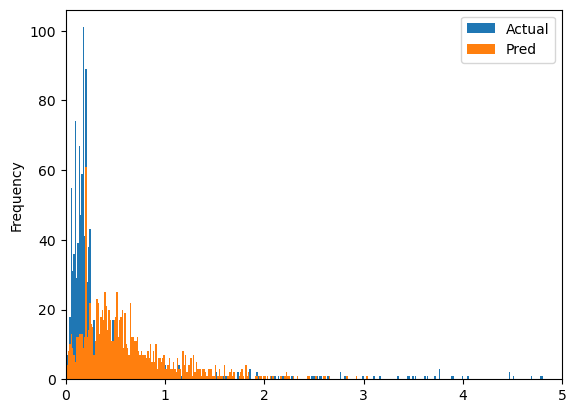

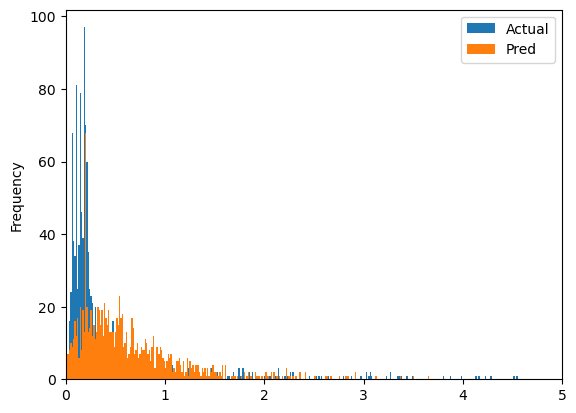

In [264]:
comparision_df_svr_nlp.plot(kind='hist',bins=1000,xlim=(0,5))
comparision_df_svr_valid_nlp.plot(kind='hist',bins=1000,xlim=(0,5))

In [265]:
def scheduler(epoch, lr):
    if epoch % 100:
        return lr
    else:
        return lr * 0.1

callback = keras.callbacks.LearningRateScheduler(scheduler)
D1=256
D2=128
D3=64
lr=1e-5

my_nn_nlp=Sequential()
my_nn_nlp.add(Dense(D1,input_dim=X_train_nlp.shape[1]))
# my_nn.add(Dropout(0.1))
my_nn_nlp.add(BatchNormalization())
my_nn_nlp.add(Dense(D2,input_dim=D1,activation='relu'))
# my_nn.add(Dropout(0.1))
my_nn_nlp.add(Dense(D3,input_dim=D2,activation='relu'))
# my_nn.add(Dropout(0.1))
my_nn_nlp.add(BatchNormalization())
my_nn_nlp.add(Dense(1,input_dim=D3)) #Output shape is 1 because we're doing regression
print(my_nn_nlp.summary())
opt=keras.optimizers.Adam(learning_rate=lr)
my_nn_nlp.compile(loss='mean_squared_error', optimizer='adam')
my_nn_nlp.fit(X_train_nlp,y_train_nlp,verbose=1,epochs=100)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_149 (Dense)           (None, 256)               1663232   
                                                                 
 batch_normalization_107 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 dense_150 (Dense)           (None, 128)               32896     
                                                                 
 dense_151 (Dense)           (None, 64)                8256      
                                                                 
 batch_normalization_108 (B  (None, 64)                256       
 atchNormalization)                                              
                                                                 
 dense_152 (Dense)           (None, 1)               

307/307 [==============================] - 6s 20ms/step - loss: 0.1917
Epoch 83/100
307/307 [==============================] - 6s 19ms/step - loss: 0.1926
Epoch 84/100
307/307 [==============================] - 6s 19ms/step - loss: 0.1896
Epoch 85/100
307/307 [==============================] - 6s 19ms/step - loss: 0.1965
Epoch 86/100
307/307 [==============================] - 6s 19ms/step - loss: 0.1934
Epoch 87/100
307/307 [==============================] - 6s 19ms/step - loss: 0.1844
Epoch 88/100
307/307 [==============================] - 6s 19ms/step - loss: 0.2064
Epoch 89/100
307/307 [==============================] - 6s 19ms/step - loss: 0.1959
Epoch 90/100
307/307 [==============================] - 6s 19ms/step - loss: 0.1973
Epoch 91/100
307/307 [==============================] - 6s 19ms/step - loss: 0.1853
Epoch 92/100
307/307 [==============================] - 6s 19ms/step - loss: 0.1856
Epoch 93/100
307/307 [==============================] - 6s 19ms/step - loss: 0.1854
Epoch

In [266]:
y_pred_nn_nlp = my_nn_nlp.predict(X_test_nlp)
y_pred_nn_nlp_true = y_pred_nn_nlp[:,0]
# Measure RMSE error.  
score_nlp = metrics.r2_score(y_test_nlp,y_pred_nn_nlp_true)
print("Final score (R2): {}".format(metrics.r2_score(y_test_nlp,y_pred_nn_nlp_true)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test_nlp,y_pred_nn_nlp_true))))
print(y_pred_nn_nlp_true.shape)
print(y_test_nlp.shape)
comparision_df_nn_nlp=pd.DataFrame({'Actual':y_test_nlp,'Pred':y_pred_nn_nlp_true})
comparision_df_nn_nlp.head()

39/39 [==============================] - 0s 4ms/step
Final score (R2): -0.08863513828599046
Final score (RMSE): 1.4015153068062651
(1225,)
(1225,)


,Actual,Pred
0,0.13,0.275696
1,0.47,0.067379
2,8.71,0.594653
3,0.16,0.480637
4,0.20,2.544179


# Random Forest for NLP

In [ ]:
rf_nlp=RandomForestRegressor(n_estimators=50)
rf_nlp.fit(X_train_nlp,y_train_nlp)
ypred_rf_nlp=rf_nlp.predict(X_test_nlp)

# score_rf_nlp = metrics.r2_score(y_test_nlp,ypred_rf_nlp)
print("Final score (R2): {}".format(metrics.r2_score(y_test_nlp,ypred_rf_nlp)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test_nlp,ypred_rf_nlp))))
# print(ypred_rf_nlp.shape)
# print(y_test_nlp.shape)
comparision_df_rf_nn_nlp=pd.DataFrame({'Actual':y_test_nlp,'Pred':ypred_rf_nlp})
comparision_df_rf_nn_nlp.head()

ypred_rf_nlp_valid=rf_nlp.predict(X_valid_nlp)

# score_rf_nlp = metrics.r2_score(y_test_nlp,ypred_rf_nlp)
print("Final score (R2): {}".format(metrics.r2_score(y_valid_nlp,ypred_rf_nlp_valid)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_valid_nlp,ypred_rf_nlp_valid))))
comparision_df_rf_nn_nlp_valid=pd.DataFrame({'Actual':y_valid_nlp,'Pred':ypred_rf_nlp_valid})
comparision_df_rf_nn_nlp_valid.head()

# Feature Selection

## Random Forest Regressor

<BarContainer object of 15 artists>

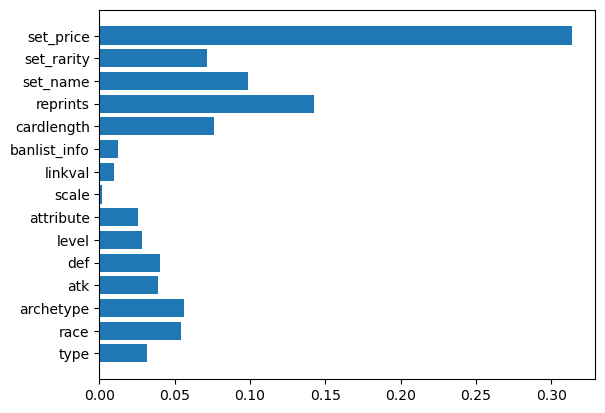

In [120]:
forestreg=RandomForestRegressor(n_estimators=50,random_state=42)
forestreg.fit(X,y)

gamma=forestreg.feature_importances_
plt.barh(columns,gamma)

In [134]:
#Remove unwanted features
X_filtered=X[:,gamma>0.06]
columns_filtered=columns[gamma>0.06]
print('number of columns after feature selection is: {}'.format(len(columns_filtered)))
print('columns picked are: {}'.format(columns_filtered))

number of columns after feature selection is: 5
columns picked are: Index(['cardlength', 'reprints', 'set_name', 'set_rarity', 'set_price'], dtype='object')


# Split train and test set

In [135]:
#split the dataset, random_state for replication
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.20, random_state=seed, shuffle=True) 
X_test,X_valid,y_test,y_valid=train_test_split(X_test,y_test,test_size=0.50,random_state=seed, shuffle=True)

# Linear Regression (BASELINE)

In [144]:
linreg_model = LinearRegression()
linreg_model.fit(X_train,y_train)
ypred_linreg=linreg_model.predict(X_test)
ypred_linreg_valid=linreg_model.predict(X_valid)
# print(features)
# print(columns)
# print(features.shape)


# Comparision (Linear Regression)

In [145]:
comparision_df_linreg=pd.DataFrame({'Actual':y_test,'Pred':ypred_linreg})
comparision_df_linreg_valid=pd.DataFrame({'Actual':y_valid,'Pred':ypred_linreg_valid})
print('R2 test:', np.sqrt(metrics.r2_score(y_test, ypred_linreg)))
print('RMSE test:', np.sqrt(metrics.mean_squared_error(y_test, ypred_linreg)))

print('R2 valid:', np.sqrt(metrics.r2_score(y_valid, ypred_linreg_valid)))
print('RMSE valid:', np.sqrt(metrics.mean_squared_error(y_valid, ypred_linreg_valid)))
comparision_df_linreg.head(25)

R2 test: 0.28671110283945583
RMSE test: 1.2868559279438108
R2 valid: 0.22494342996863267
RMSE valid: 1.1008973919925875


,Actual,Pred
0,0.13,0.240492
1,0.47,0.264581
2,8.71,0.713358
3,0.16,0.490333
4,0.20,0.264155
5,0.25,0.817438
6,0.17,0.307110
7,0.17,0.261769
8,0.21,0.504284
9,0.92,1.052078


RMSE: 1.2868559279438108


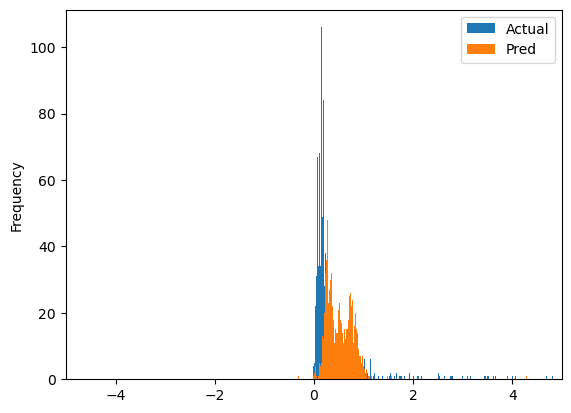

In [146]:
comparision_df_linreg.plot(kind='hist',bins=1000,xlim=(-5,5))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_linreg)))
# comparision_df_linreg['Actual']

<BarContainer object of 5 artists>

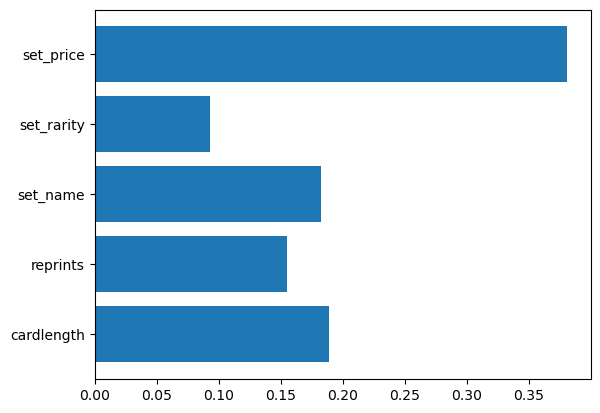

In [147]:
forestreg=RandomForestRegressor(n_estimators=100,random_state=seed)
forestreg.fit(X_filtered,y)

gamma=forestreg.feature_importances_
plt.barh(columns_filtered,gamma)

In [148]:
ypred_forestreg=forestreg.predict(X_test)
comparision_df_forestreg=pd.DataFrame({'Actual':y_test,'Pred':ypred_forestreg})

print('R2 score:', metrics.r2_score(y_test, ypred_forestreg))
print('RMSE score:', np.sqrt(metrics.mean_squared_error(y_test, ypred_forestreg)))
# comparision_df_forestreg.head(25)

ypred_forestreg_valid=forestreg.predict(X_valid)
comparision_df_forestreg_valid=pd.DataFrame({'Actual':y_valid,'Pred':ypred_forestreg_valid})


print('R2 score:', metrics.r2_score(y_valid, ypred_forestreg_valid))
print('RMSE score:', np.sqrt(metrics.mean_squared_error(y_valid, ypred_forestreg_valid)))
comparision_df_forestreg_valid.head(25)

R2 score: 0.9213400259405315
RMSE score: 0.3767329190819872
R2 score: 0.8886733361657473
RMSE score: 0.3769829623485072


,Actual,Pred
0,2.85,2.082800
1,0.08,0.121500
2,3.34,2.977224
3,0.11,0.164600
4,0.09,0.105067
5,0.17,0.186000
6,0.16,0.205500
7,0.23,0.268300
8,0.74,0.733000
9,0.19,0.166300


<Axes: ylabel='Frequency'>

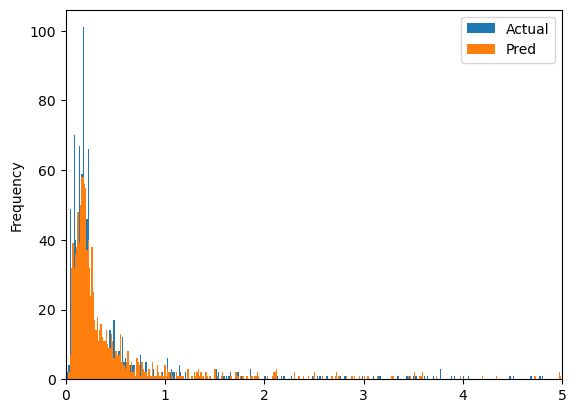

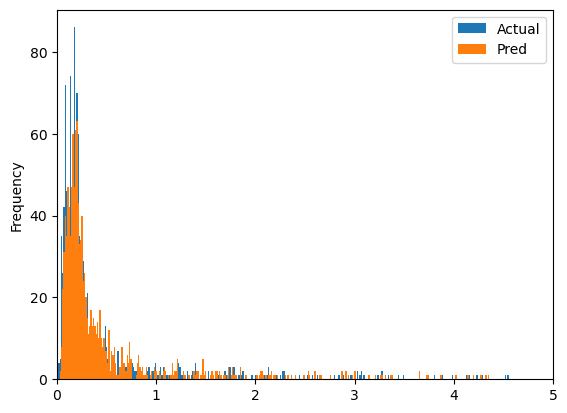

In [149]:
comparision_df_forestreg.plot(kind='hist',bins=1000,xlim=(0,5))
comparision_df_forestreg_valid.plot(kind='hist',bins=1000,xlim=(0,5))
# comparision_df_linreg['Actual']

# Decision Tree

In [150]:
tree1 = DecisionTreeRegressor(max_depth=5, random_state=seed)
tree2 = DecisionTreeRegressor(max_depth=1, random_state=seed)
tree1.fit(X_train, y_train)
tree2.fit(X_train, y_train)

ypred_tree1=tree1.predict(X_test)
ypred_tree2=tree2.predict(X_test)

comparision_df_tree1=pd.DataFrame({'Actual':y_test,'Pred':ypred_tree1})
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_tree1)))
print('R2 score:', metrics.r2_score(y_test, ypred_tree1))
comparision_df_tree2=pd.DataFrame({'Actual':y_test,'Pred':ypred_tree2})
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_tree2)))
print('R2 score:', metrics.r2_score(y_test, ypred_tree2))

comparision_df_tree1.head(25)

RMSE: 1.0357508265201543
R2 score: 0.40543788273395986
RMSE: 1.2644402601628426
R2 score: 0.1138988741233582


,Actual,Pred
0,0.13,0.125306
1,0.47,0.285637
2,8.71,8.550000
3,0.16,0.209804
4,0.20,0.429543
5,0.25,0.209804
6,0.17,1.780627
7,0.17,0.125306
8,0.21,0.209804
9,0.92,1.104151


<Axes: ylabel='Frequency'>

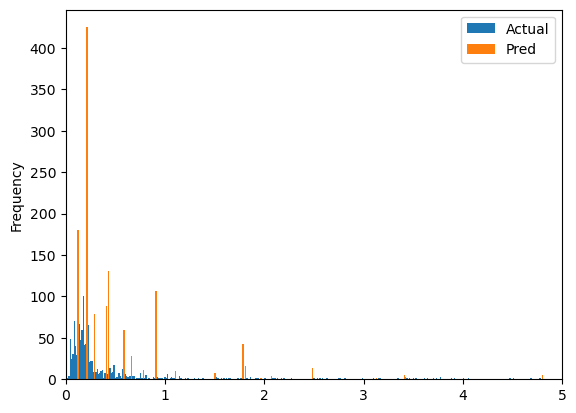

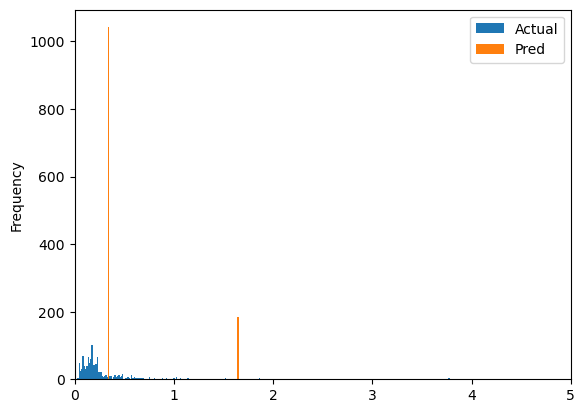

In [151]:
comparision_df_tree1.plot(kind='hist',bins=1000,xlim=(0,5))
comparision_df_tree2.plot(kind='hist',bins=1000,xlim=(0,5))

# SVR

In [152]:
svm_model = SVR(C=20).fit(X_train, y_train)

ypred_svr = svm_model.predict(X_test)
# print('RMSE:', (metrics.mean_squared_error(y_test, ypred_svr)))
comparision_df_svr=pd.DataFrame({'Actual':y_test,'Pred':ypred_svr})

print('R2 score:', metrics.r2_score(y_test, ypred_svr))
print('RMSE testing:', np.sqrt(metrics.mean_squared_error(y_test, ypred_svr)))
# beta=svm_model.dual_coef_
# plt.barh(columns,beta)
ypred_svr_valid = svm_model.predict(X_valid)
# print('RMSE:', (metrics.mean_squared_error(y_test, ypred_svr)))

comparision_df_svr_valid=pd.DataFrame({'Actual':y_valid,'Pred':ypred_svr_valid})

print('R2 score:', metrics.r2_score(y_valid, ypred_svr_valid))
print('RMSE validation:', np.sqrt(metrics.mean_squared_error(y_valid, ypred_svr_valid)))

R2 score: 0.14810141063211524
RMSE testing: 1.2397971133159102
R2 score: 0.045750933980912234
RMSE validation: 1.1037049677145239


<Axes: ylabel='Frequency'>

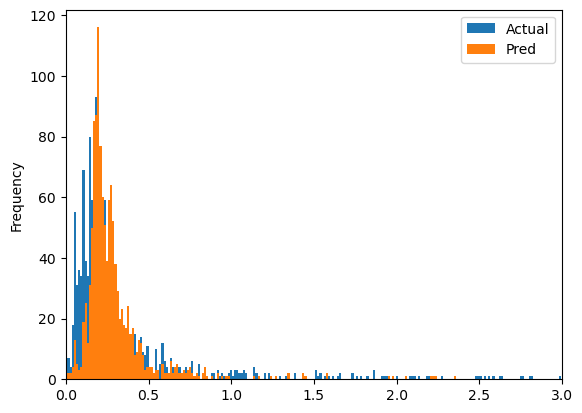

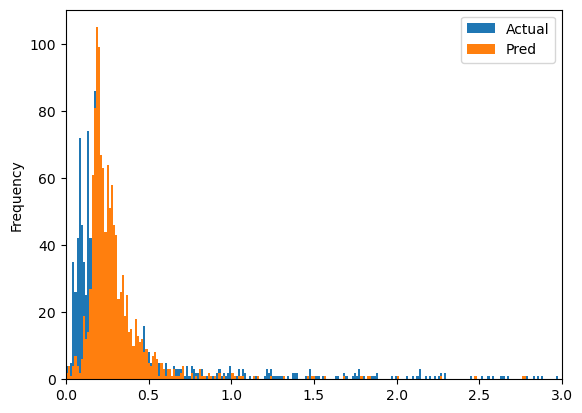

In [153]:
comparision_df_svr.plot(kind='hist',bins=1000,xlim=(0,3))
comparision_df_svr_valid.plot(kind='hist',bins=1000,xlim=(0,3))

# Neural Networks

In [259]:
def scheduler(epoch, lr):
    if epoch % 10:
        return lr 
    else:
        return lr *0.90

callback = keras.callbacks.LearningRateScheduler(scheduler)
epochs=200
D1=256
D2=128
D3=64
lr=1e-6
# D3=128
# D4=64
my_nn=Sequential()
my_nn.add(Dense(D1,input_dim=X_filtered.shape[1],kernel_regularizer=regularizers.L1L2(l1=1e-7, l2=1e-6),activation='relu'))
my_nn.add(BatchNormalization())
my_nn.add(Dense(D2,input_dim=D1,kernel_regularizer=regularizers.L1L2(l1=1e-7, l2=1e-6),activation='relu'))
# my_nn.add(Dropout(0.1))
my_nn.add(BatchNormalization())
my_nn.add(Dense(D3,input_dim=D2,kernel_regularizer=regularizers.L1L2(l1=1e-7, l2=1e-6),activation='relu'))
# my_nn.add(Dropout(0.1))
my_nn.add(BatchNormalization())
my_nn.add(Dense(1,kernel_regularizer=regularizers.L1L2(l1=1e-7, l2=1e-6),activation='relu')) #Output shape is 1 because we're doing regression
# print(my_nn.summary())
opt=keras.optimizers.Adam(learning_rate=lr)
my_nn.compile(loss='mean_squared_error', optimizer='sgd',metrics=['mse'])
my_nn.fit(X_train,y_train,verbose=1,batch_size=16,epochs=epochs)#, callbacks=[callback])

Epoch 1/200
613/613 [==============================] - 4s 3ms/step - loss: 1.5889 - mse: 1.5883
Epoch 2/200
613/613 [==============================] - 2s 3ms/step - loss: 1.4184 - mse: 1.4178
Epoch 3/200
613/613 [==============================] - 2s 3ms/step - loss: 1.3985 - mse: 1.3979
Epoch 4/200
613/613 [==============================] - 2s 3ms/step - loss: 1.3419 - mse: 1.3413
Epoch 5/200
613/613 [==============================] - 2s 3ms/step - loss: 1.3464 - mse: 1.3457
Epoch 6/200
613/613 [==============================] - 2s 3ms/step - loss: 1.3315 - mse: 1.3309
Epoch 7/200
613/613 [==============================] - 2s 3ms/step - loss: 1.3158 - mse: 1.3152
Epoch 8/200
613/613 [==============================] - 2s 3ms/step - loss: 1.2885 - mse: 1.2879
Epoch 9/200
613/613 [==============================] - 2s 3ms/step - loss: 1.2721 - mse: 1.2714
Epoch 10/200
613/613 [==============================] - 2s 3ms/step - loss: 1.2659 - mse: 1.2653
Epoch 11/200
613/613 [=================

613/613 [==============================] - 2s 3ms/step - loss: 1.1406 - mse: 1.1398
Epoch 86/200
613/613 [==============================] - 2s 3ms/step - loss: 1.1251 - mse: 1.1243
Epoch 87/200
613/613 [==============================] - 2s 3ms/step - loss: 1.1487 - mse: 1.1479
Epoch 88/200
613/613 [==============================] - 2s 3ms/step - loss: 1.1341 - mse: 1.1332
Epoch 89/200
613/613 [==============================] - 2s 3ms/step - loss: 1.1241 - mse: 1.1233
Epoch 90/200
613/613 [==============================] - 2s 3ms/step - loss: 1.0994 - mse: 1.0986
Epoch 91/200
613/613 [==============================] - 2s 3ms/step - loss: 1.1229 - mse: 1.1221
Epoch 92/200
613/613 [==============================] - 2s 3ms/step - loss: 1.1262 - mse: 1.1254
Epoch 93/200
613/613 [==============================] - 2s 3ms/step - loss: 1.1251 - mse: 1.1243
Epoch 94/200
613/613 [==============================] - 2s 3ms/step - loss: 1.1216 - mse: 1.1208
Epoch 95/200
613/613 [=====================

613/613 [==============================] - 2s 3ms/step - loss: 1.0826 - mse: 1.0816
Epoch 169/200
613/613 [==============================] - 2s 3ms/step - loss: 1.0708 - mse: 1.0698
Epoch 170/200
613/613 [==============================] - 2s 3ms/step - loss: 1.1021 - mse: 1.1011
Epoch 171/200
613/613 [==============================] - 2s 3ms/step - loss: 1.0996 - mse: 1.0986
Epoch 172/200
613/613 [==============================] - 2s 3ms/step - loss: 1.0785 - mse: 1.0776
Epoch 173/200
613/613 [==============================] - 2s 3ms/step - loss: 1.0708 - mse: 1.0698
Epoch 174/200
613/613 [==============================] - 2s 3ms/step - loss: 1.0602 - mse: 1.0592
Epoch 175/200
613/613 [==============================] - 2s 3ms/step - loss: 1.0655 - mse: 1.0645
Epoch 176/200
613/613 [==============================] - 2s 3ms/step - loss: 1.0746 - mse: 1.0736
Epoch 177/200
613/613 [==============================] - 2s 3ms/step - loss: 1.0836 - mse: 1.0825
Epoch 178/200
613/613 [===========

In [256]:
y_pred_nn = my_nn.predict(X_test)
y_pred_nn = y_pred_nn[:,0]
# Measure RMSE error.  
print("Final score (R2): {}".format(metrics.r2_score(y_test,y_pred_nn)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_nn))))
# print(y_pred_nn_true.shape)
# print(y_test.shape)
comparision_df_nn=pd.DataFrame({'Actual':y_test,'Pred':y_pred_nn})
# comparision_df_nn[comparision_df_nn.Pred>0]

y_pred_nn_valid = my_nn.predict(X_valid)
y_pred_nn_valid = y_pred_nn_valid[:,0]
# Measure RMSE error.  
print("Final score (R2): {}".format(metrics.r2_score(y_valid,y_pred_nn_valid)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_valid,y_pred_nn_valid))))
# print(y_pred_nn_true.shape)
# print(y_test.shape)
comparision_df_nn_valid=pd.DataFrame({'Actual':y_valid,'Pred':y_pred_nn_valid})
# comparision_df_nn_valid[comparision_df_nn_valid.Pred>0]

39/39 [==============================] - 0s 2ms/step
Final score (R2): 0.407703720771314
Final score (RMSE): 1.0337753526882796
39/39 [==============================] - 0s 2ms/step
Final score (R2): 0.1304840008480782
Final score (RMSE): 1.0535639800190109


In [257]:
y_pred_nn_train = my_nn.predict(X_train)
print("Final score (R2): {}".format(metrics.r2_score(y_train,y_pred_nn_train)))
print("Final score (RMSE): {}".format(np.sqrt(metrics.mean_squared_error(y_train,y_pred_nn_train))))

307/307 [==============================] - 1s 2ms/step
Final score (R2): -63.03809025762513
Final score (RMSE): 9.773307712437038


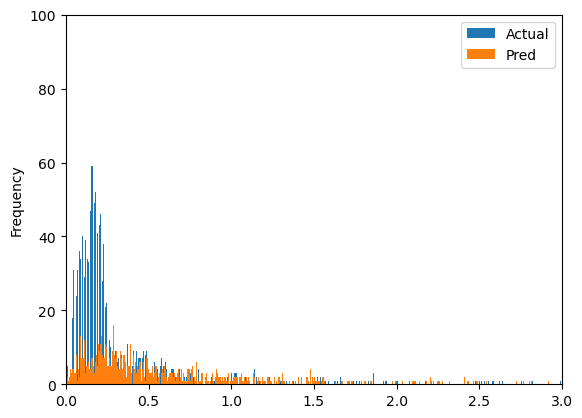

In [258]:
comparision_df_nn.plot(kind='hist',bins=2000,xlim=(0,3),ylim=(0,100))
plt.show()